In [4]:
## load GYM data:
from src.zootransform.dataset.protein_gym_download_and_clean import download_gym_data, get_gym_data
from src.zootransform.validation.visualization import plot_loglikelihood_vs_dmscore
from src.zootransform.utils.utils import DEVICE, compute_sequence_likelihoods
from transformers import AutoTokenizer, AutoModelForMaskedLM
import torch

download_gym_data()
data = get_gym_data()
print(data.head())


model_name = "facebook/esm2_t6_8M_UR50D"

model_pre = AutoModelForMaskedLM.from_pretrained(model_name).to(DEVICE)
tokenizer_pre = AutoTokenizer.from_pretrained(model_name)

/a/home/cc/students/cs/kupershmidt/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/bnet/kupershmidt/ZooTransform
Loading CSV files...
✓ Loaded 10 files with 50,376 total rows
   DMS_score                                   mutated_sequence protein  \
0  -0.144916  HSQKRVVVLGSGVIGLSSALILARKGYSVHILARDLPEDVSSQTFA...    OXDA   
1  -0.088513  HSQKRVVVLGSGVIGLSSALILARKGYSVHILARDLPEDVSSQTFA...    OXDA   
2  -0.118531  HSQKRVVVLGSGVIGLSSALILARKGYSVHILARDLPEDVSSQTFA...    OXDA   
3  -0.087970  HSQKRVVVLGSGVIGLSSALILARKGYSVHILARDLPEDVSSQTFA...    OXDA   
4  -0.080127  HSQKRVVVLGSGVIGLSSALILARKGYSVHILARDLPEDVSSQTFA...    OXDA   

         species  
0  RHOTO_Vanella  
1  RHOTO_Vanella  
2  RHOTO_Vanella  
3  RHOTO_Vanella  
4  RHOTO_Vanella  


2025-11-05 22:06:17.556388: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762373179.091310  750738 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762373179.447987  750738 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762373182.365871  750738 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762373182.365919  750738 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762373182.365921  750738 computation_placer.cc:177] computation placer alr

In [10]:
from transformers import AutoModelForMaskedLM, AutoTokenizer
from peft import PeftModel, PeftConfig

peft_model_path = "./finetuned20"

tokenizer_tuned = AutoTokenizer.from_pretrained(peft_model_path)

# Load adapter config locally
config = PeftConfig.from_pretrained(peft_model_path)

# Load base model
base_model = AutoModelForMaskedLM.from_pretrained(config.base_model_name_or_path)
base_model.resize_token_embeddings(len(tokenizer_tuned))

old_bias = base_model.lm_head.bias
old_vocab_size = old_bias.size(0)
new_vocab_size = len(tokenizer_tuned)

if old_vocab_size != new_vocab_size:
    print(f"Resizing lm_head.bias: {old_vocab_size} → {new_vocab_size}")
    new_bias = torch.zeros(new_vocab_size, device=old_bias.device, dtype=old_bias.dtype)
    # Copy over the old bias values
    new_bias[:old_vocab_size] = old_bias
    base_model.lm_head.bias = torch.nn.Parameter(new_bias)

# Load LoRA weights locally
model_tuned = PeftModel.from_pretrained(base_model, peft_model_path)



The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Resizing lm_head.bias: 33 → 45


In [14]:

sequences = data["mutated_sequence"].tolist()


# _, likelihoods_pre = compute_sequence_likelihoods(sequences=sequences, model=model_pre, tokenizer=tokenizer_pre)
_, likelihhods = compute_sequence_likelihoods(sequences=sequences, model=model_tuned.to(DEVICE), tokenizer=tokenizer_tuned)

  0%|          | 0/99 [00:00<?, ?it/s]

100%|██████████| 99/99 [02:41<00:00,  1.63s/it]


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_loglikelihood_vs_dmscore(df):
    """
    Plots LogLikelihood and LogLikelihoodPre against DMS_score for each species,
    arranging species plots in a 3 by 3 grid (for 9 species).
    """
    unique_species = df['Species'].unique()
    num_species = len(unique_species)
    
    nrows, ncols = 3, 3  # Fixed 3x3 grid
    total_plots = nrows * ncols

    fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 5 * nrows), sharey=True)
    axes = axes.flatten()

    # Pad species list to match grid size for proper looping
    padded_species = list(unique_species) + [None] * (total_plots - num_species)

    for i, sp in enumerate(padded_species):
        ax = axes[i]
        if sp is None:
            ax.set_visible(False)
            continue

        species_data = df[df['Species'] == sp]

        sns.scatterplot(
            x='Likelihood', y='DMS_score',
            data=species_data, ax=ax,
            label='Likelihood', s=60, alpha=0.7, color='#1f77b4'
        )
        sns.scatterplot(
            x='LikelihoodPre', y='DMS_score',
            data=species_data, ax=ax,
            label='LikelihoodPre', s=60, alpha=0.7, color='#ff7f0e'
        )

        sns.regplot(
            x='Likelihood', y='DMS_score',
            data=species_data, ax=ax,
            scatter=False, color='#1f77b4', ci=None, line_kws={'lw': 2, 'ls': '--'}
        )
        sns.regplot(
            x='LikelihoodPre', y='DMS_score',
            data=species_data, ax=ax,
            scatter=False, color='#ff7f0e', ci=None, line_kws={'lw': 2, 'ls': '--'}
        )

        ax.set_title(sp, fontsize=16, weight='bold')
        ax.set_xlabel('Likelihood', fontsize=14)
        ax.set_ylabel('DMS Score', fontsize=14)
        ax.legend(frameon=True, fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.4)

    plt.tight_layout()
    plt.show()


In [23]:
data['Species'] = data['Species'].map(lambda x: x.split('_')[0])

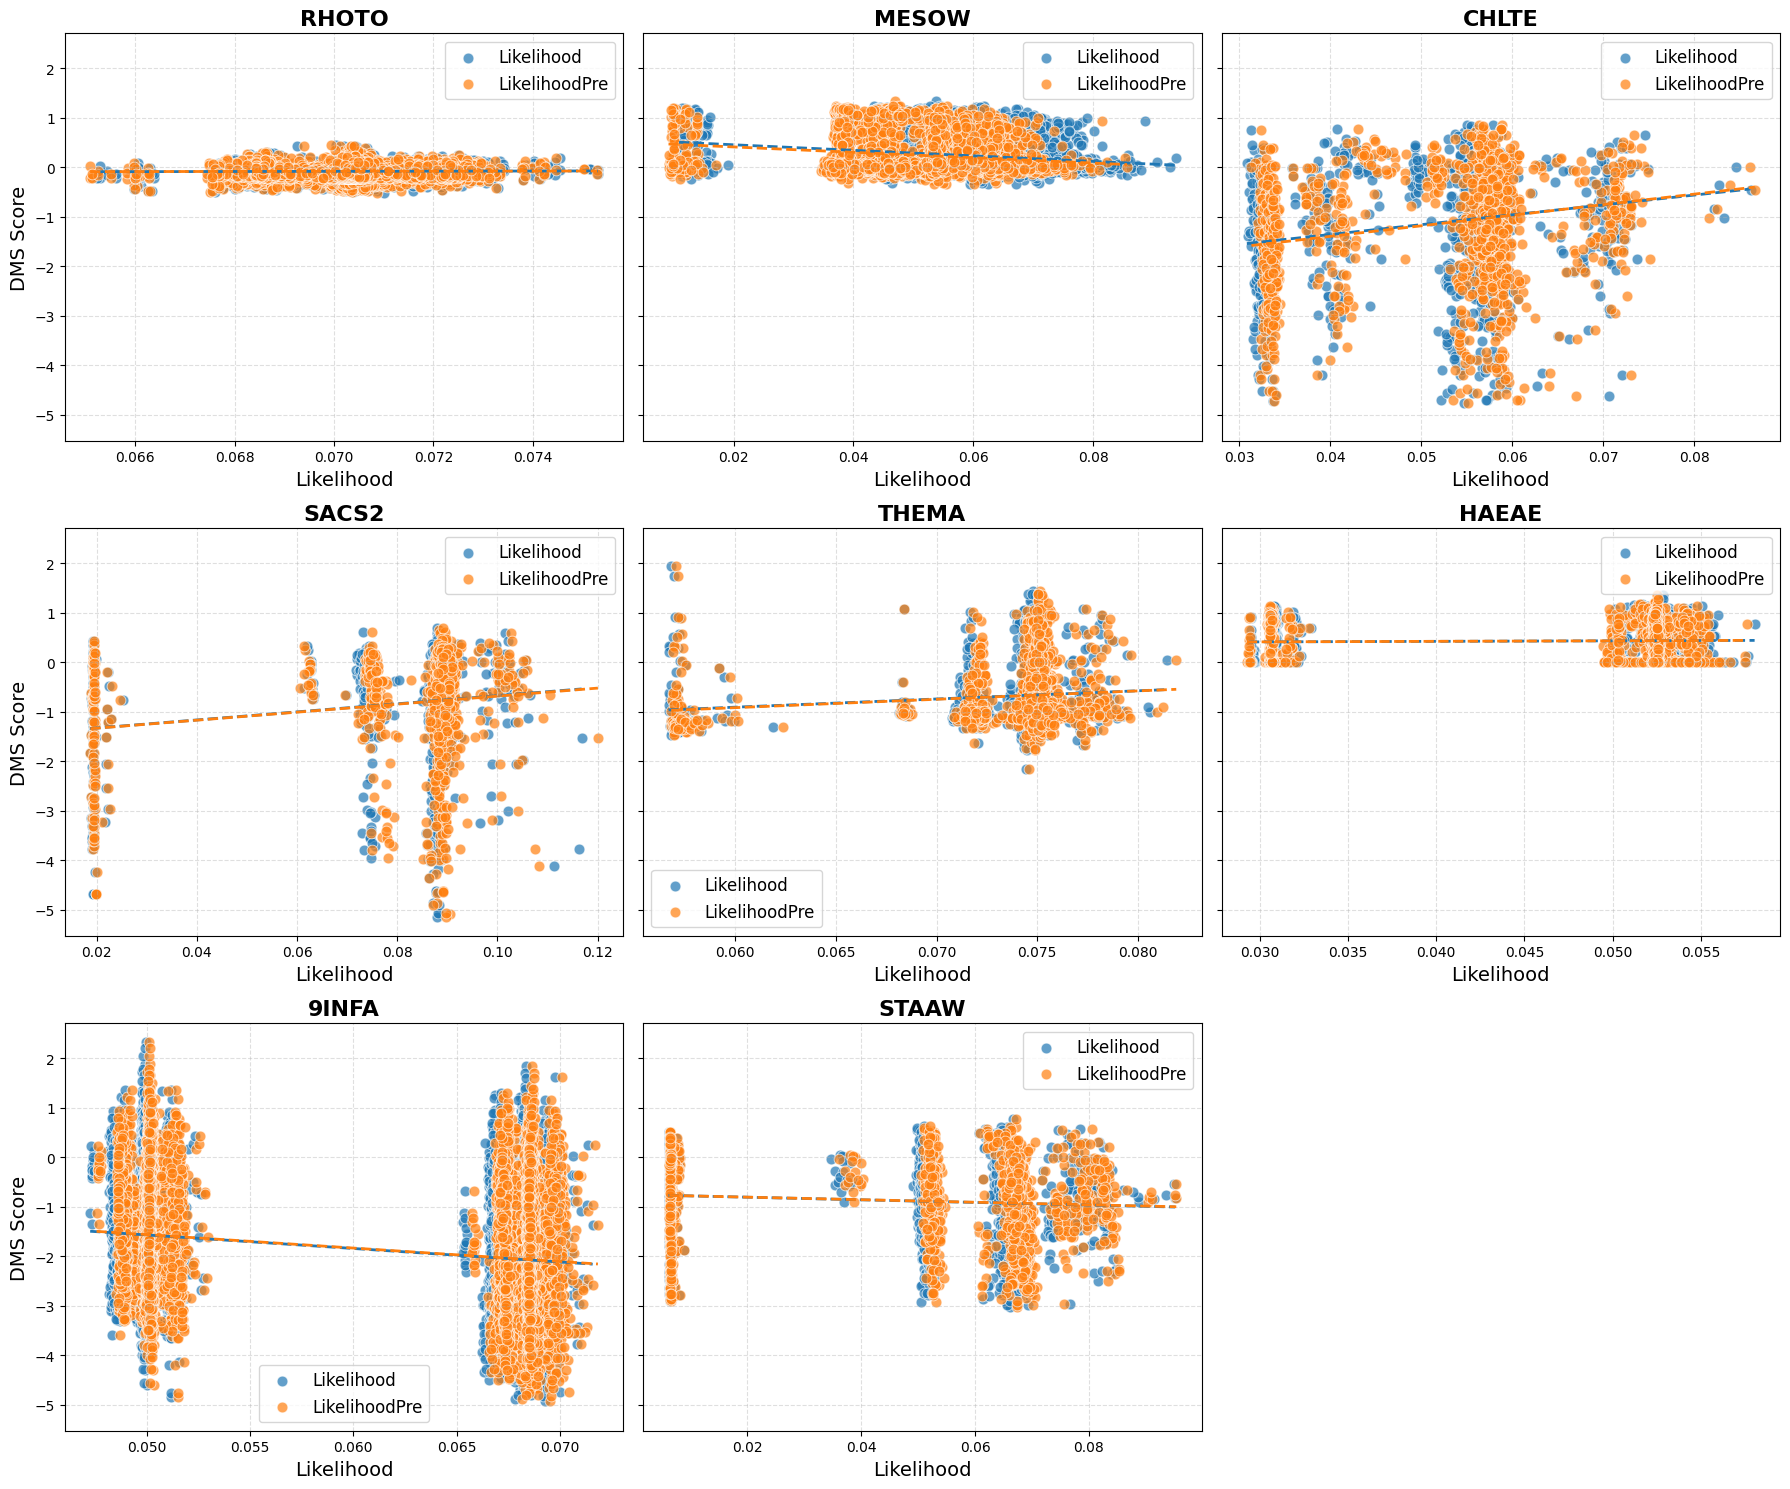

In [24]:
# tmp = data.iloc[:10]

data['LikelihoodPre'] = likelihoods_pre
data['Likelihood'] = likelihhods
data.rename(columns={'species': 'Species'}, inplace=True)
plot_loglikelihood_vs_dmscore(data)